### **BPIC 2012 - W_Calling after sent offers**


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [3]:
milestone = 'W_Calling after sent offers' #,'All'
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
timelapsed = 'total' #'total', 'incremental'
n_size = 5

### Setting up the key parameters


In [ ]:
# For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [5]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)


###Data Preprocessing

In [ ]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name'])
  log_df = log_df.reset_index(drop=True)

if timelapsed == 'incremental':
  log_df['timelapsed'] = log_df['timelapsed_2']

log_df.head()

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,timelapsed_2
0,173898_3,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,W_Calling after sent offers,W_Filling in information for the application,3,1,0
1,173898_2,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,A_ACCEPTED,W_Filling in information for the application,2,1,0
2,173898_4,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,O_CANCELLED,W_Calling after sent offers,4,1,0
3,173898_3,173898,A_PARTLYSUBMITTED,role_112,2011-10-03 00:05:40.0090000,2011-10-03 00:05:39.8170000,0,W_Calling after sent offers,W_Filling in information for the application,3,2,0
4,173898_2,173898,A_PARTLYSUBMITTED,role_112,2011-10-03 00:05:40.0090000,2011-10-03 00:05:39.8170000,0,A_ACCEPTED,W_Filling in information for the application,2,2,0


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [ ]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]

#### Data Analysis

In [ ]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_ACTIVATED                                       68
A_APPROVED                                       163
A_CANCELLED                                      745
A_DECLINED                                       201
A_REGISTERED                                      71
O_ACCEPTED                                       342
O_CANCELLED                                     1119
O_DECLINED                                       194
O_SELECTED                                       450
O_SENT_BACK                                     2693
W_Assessing the application                     2114
W_Filling in information for the application       4
Name: prefix_id, dtype: int64


We can see that there is an imbalance in the dataset, by the next activity name, as well as a very high dimensionality in the target variable.
Therefore, we can reduce the imbalance and high dimensionality of data by grouping some of the activity name.


Balancing the dataset


In [ ]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
    'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
    'A_APPROVED':  'A_APPROVED_ACTIVATED',
    'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
    'A_DECLINED': 'A_CANCELLED_DECLINED' ,
    'A_PARTLYSUBMITTED': 'REDUNDANT',
    'A_PREACCEPTED':'A_PREACCEPTED',
    'A_REGISTERED' : 'REDUNDANT',
    'O_ACCEPTED' : 'REDUNDANT',
    'O_CANCELLED' :  'O_CANCELLED_DECLINED' ,
    'O_CREATED':'REDUNDANT',
    'O_DECLINED' :'O_CANCELLED_DECLINED' ,
    'O_SELECTED' : 'REDUNDANT', 
    'O_SENT':'O_SENT',
    'O_SENT_BACK' : 'O_SENT_BACK',
    'W_Afhandelen leads' :  'W_Afhandelen leads',
    'W_Completeren aanvraag': 'W_Completeren aanvraag',
    'W_Filling in information for the application':'W_Filling in information for the application',
    'W_Calling after sent offers':'W_Calling after sent offers',
    'W_Assessing the application' : 'W_Assessing the application'}


  df['next_activity'].replace(group_dict, inplace=True)
  #Dropping the minority classes
  df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [ ]:
log_df = balance(log_df)



#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [ ]:
# Check the balance

print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_APPROVED_ACTIVATED                             231
A_CANCELLED_DECLINED                             946
O_CANCELLED_DECLINED                            1313
O_SENT_BACK                                     2693
W_Assessing the application                     2114
W_Filling in information for the application       4
Name: prefix_id, dtype: int64


In [ ]:
#removing a minority target
log_df = log_df.drop(log_df[log_df.next_activity == 'W_Filling in information for the application'].index)

Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [ ]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [ ]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'role_000': 1, 'role_10124': 2, 'role_10138': 3, 'role_10188': 4, 'role_10228': 5, 'role_10609': 6, 'role_10629': 7, 'role_10779': 8, 'role_10789': 9, 'role_10809': 10, 'role_10859': 11, 'role_10861': 12, 'role_10862': 13, 'role_10863': 14, 'role_10880': 15, 'role_10881': 16, 'role_10889': 17, 'role_10899': 18, 'role_10909': 19, 'role_10910': 20, 'role_10912': 21, 'role_10913': 22, 'role_10914': 23, 'role_10929': 24, 'role_10931': 25, 'role_10932': 26, 'role_10933': 27, 'role_10935': 28, 'role_10939': 29, 'role_10971': 30, 'role_10972': 31, 'role_10982': 32, 'role_11000': 33, 'role_11001': 34, 'role_11002': 35, 'role_11003': 36, 'role_11009': 37, 'role_11019': 38, 'role_11029': 39, 'role_11049': 40, 'role_11079': 41, 'role_11111': 42, 'role_11119': 43, 'role_11120': 44, 'role_11121': 45, 'role_11122': 46, 'role_11169': 47, 'role_11179': 48, 'role_11180': 49, 'role_11181': 50, 'role_11189': 51, 'role_112': 52, 'role_11200': 53, 'role_11201': 54, 'role_11202': 55, 'role_11203

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,timelapsed_2,ac_index,rl_index,ne_index
2,173898_4,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,O_CANCELLED_DECLINED,W_Calling after sent offers,4,1,0,6,52,2
5,173898_4,173898,A_PARTLYSUBMITTED,role_112,2011-10-03 00:05:40.0090000,2011-10-03 00:05:39.8170000,0,O_CANCELLED_DECLINED,W_Calling after sent offers,4,2,0,4,52,2
8,173898_4,173898,A_PREACCEPTED,role_10889,2011-10-03 17:37:05.9680000,2011-10-03 00:05:39.8170000,17,O_CANCELLED_DECLINED,W_Calling after sent offers,4,3,17,5,17,2
11,173898_4,173898,W_Fixing incoming lead,role_10889,2011-10-03 17:37:07.2610000,2011-10-03 00:05:39.8170000,17,O_CANCELLED_DECLINED,W_Calling after sent offers,4,4,0,15,17,2
14,173898_4,173898,W_Filling in information for the application,role_000,2011-10-03 21:58:22.0150000,2011-10-03 00:05:39.8170000,21,O_CANCELLED_DECLINED,W_Calling after sent offers,4,5,4,14,1,2


In [ ]:
print(ne_index)

{'A_APPROVED_ACTIVATED': 0, 'A_CANCELLED_DECLINED': 1, 'O_CANCELLED_DECLINED': 2, 'O_SENT_BACK': 3, 'W_Assessing the application': 4}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [ ]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [ ]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [ ]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:5108
Number of traces in test set is:2189


In [ ]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
A_APPROVED_ACTIVATED            157
A_CANCELLED_DECLINED            638
O_CANCELLED_DECLINED            930
O_SENT_BACK                    1897
W_Assessing the application    1486
Name: prefix_id, dtype: int64

test dataset
next_activity
A_APPROVED_ACTIVATED            74
A_CANCELLED_DECLINED           308
O_CANCELLED_DECLINED           383
O_SENT_BACK                    796
W_Assessing the application    628
Name: prefix_id, dtype: int64



Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [ ]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[200])

{'caseid': '184270_4', 'ac_order': [13, 13, 13, 14, 10, 8, 3, 9, 1, 14, 14, 14, 14, 5, 4, 6], 'rl_order': [16, 1, 45, 45, 45, 45, 45, 45, 45, 45, 45, 54, 1, 52, 52, 52], 'tbtw': [1.3260224673890262, 1.32430867824182, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.47385408599814755, 0.2616084848951091, 0.13767749871470736, -1.1919807893442844, -1.1919807893442844, -1.1919807893442844], 'next_activity': 1}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [ ]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 60, training cases: 5109, test cases: 2190


converting the training log (dictionary) into a Tensor

In [ ]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [ ]:
vec_train['prefixes']['x_ac_inp']

array([[13., 11., 13., ...,  0.,  0.,  0.],
       [13., 11., 13., ...,  0.,  0.,  0.],
       [13., 13., 13., ...,  0.,  0.,  0.],
       ...,
       [13., 13., 14., ...,  0.,  0.,  0.],
       [13., 11., 13., ...,  0.,  0.,  0.],
       [13., 13., 13., ...,  0.,  0.,  0.]])

#### Generating Initial Embedding Weights for shared Model

In [ ]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


#### Saving the Processed Tensor and Other Support Data

In [ ]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [6]:
!pip3 install pyflowchart
!pip install --upgrade plotly


In [7]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [8]:
#with open(os.path.join(MILESTONE_DIR,'args.p'), 'rb') as fp:
    #args = pickle.load(fp)

with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### shared Model : (Sindhagatta et al, 2020) DOI: https://doi.org/10.1007/978-3-030-58666-9_15

In [ ]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [ ]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
ac_embedding (Embedding)        (None, 5, 16)        256         ac_input[0][0]                   
__________________________________________________________________________________________________
rl_embedding (Embedding)        (None, 5, 66)        4356        rl_input[0][0]                   
______________________________________________________________________________________________

In [ ]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [ ]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/100
17/17 [==============================] - 12s 170ms/step - loss: 1.6065 - accuracy: 0.3869 - val_loss: 1.5860 - val_accuracy: 0.6154
Epoch 2/100
17/17 [==============================] - 1s 65ms/step - loss: 1.5689 - accuracy: 0.5389 - val_loss: 1.5224 - val_accuracy: 0.7145
Epoch 3/100
17/17 [==============================] - 1s 60ms/step - loss: 1.4606 - accuracy: 0.6094 - val_loss: 1.2921 - val_accuracy: 0.7549
Epoch 4/100
17/17 [==============================] - 1s 66ms/step - loss: 1.2286 - accuracy: 0.6274 - val_loss: 1.0023 - val_accuracy: 0.7653
Epoch 5/100
17/17 [==============================] - 1s 62ms/step - loss: 1.0698 - accuracy: 0.6400 - val_loss: 0.8848 - val_accuracy: 0.7666
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 1.0061 - accuracy: 0.6435 - val_loss: 0.8419 - val_accuracy: 0.7679
Epoch 7/100
17/17 [==============================] - 1s 58ms/step - loss: 0.9718 - accuracy: 0.6509 - val_loss: 0.8197 - val_accuracy: 0.7705
Epoc

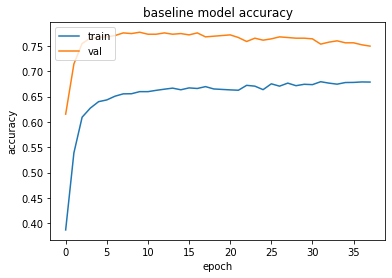

In [ ]:
plot_shared(shared_history)

In [ ]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared.save(trained_model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



##### Load Saved Model and Evaluate

In [13]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared_model = load_model(shared_trained_model)

In [14]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=100)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 2s 8ms/step - loss: 0.9025 - accuracy: 0.6571
test loss, test acc: [0.9024692177772522, 0.6570776104927063]


Classification Report

In [12]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                             precision    recall  f1-score   support

       A_APPROVED_ACTIVATED       0.00      0.00      0.00        74
       A_CANCELLED_DECLINED       0.37      0.27      0.31       308
       O_CANCELLED_DECLINED       0.31      0.11      0.16       383
                O_SENT_BACK       0.69      0.86      0.76       797
W_Assessing the application       0.76      1.00      0.86       628

                   accuracy                           0.66      2190
                  macro avg       0.42      0.45      0.42      2190
               weighted avg       0.57      0.66      0.60      2190



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

[[  0   0   0   0  74]
 [  0  83  42 127  56]
 [  0  84  42 187  70]
 [  0  54  53 689   1]
 [  0   1   0   2 625]]


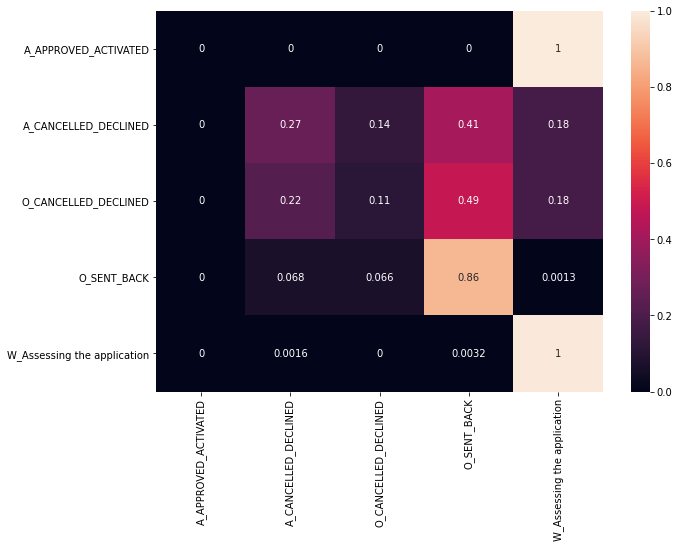

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [15]:
shared_model_attn_weights = Model(inputs=shared_model.input,
              outputs=[shared_model.output, shared_model.get_layer('timestep_attention').output, shared_model.get_layer('feature_importance').output])

shared_output_with_attention = shared_model_attn_weights.predict(x_test)

###### Global Explanations

In [22]:
shared_explain_global(shared_output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction = 2 )

###### Local Explanations

In [ ]:
df_results_shared = results_df(y_test,y_pred_shared,index_ne)
df_results_shared [(df_results_shared ['prediction'] == 'O_SENT_BACK') & (df_results_shared ['pred_class'] == False) & (df_results_shared ['prediction_prob'] >=0.7) ].head(3)

,sample_index,prediction,ground_truth,prediction_prob,pred_class
29,29,O_SENT_BACK,A_CANCELLED_DECLINED,0.7211,False
45,45,O_SENT_BACK,O_CANCELLED_DECLINED,0.7150,False
53,53,O_SENT_BACK,O_CANCELLED_DECLINED,0.7994,False


In [21]:
shared_explain_local(shared_output_with_attention,x_test,y_test,index_ac, index_rl, index_ne, 3,53) #53 false, #1 true


prediction: O_SENT_BACK
ground truth: O_CANCELLED_DECLINED
prediction probability:0.7994


process flowchart
st18=>start: start O_SENT_role:role_11169
op19=>operation: W_Filling in information for the application_role:role_11169
op20=>operation: W_Calling after sent offers_role:role_11119
op21=>operation: W_Calling after sent offers_role:role_11119
op22=>operation: W_Calling after sent offers_role:role_10982

st18->op19
op19->op20
op20->op21
op21->op22





#### specialised Model

In [ ]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [ ]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5, 16)]      0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5, 66)]      0                                            
__________________________________________________________________________________________________
t_input (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
beta_ac (Bidirectional)         (None, 5, 100)       26800       ac_input[0][0]                   
____________________________________________________________________________________________

In [ ]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [ ]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  /content/drive/My Drive/KBS-SI-Paper-main/BPIC12/models/model_updated_W_Calling after sent offers_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/100
17/17 [==============================] - 18s 288ms/step - loss: 1.6103 - accuracy: 0.3722 - val_loss: 1.5857 - val_accuracy: 0.5515
Epoch 2/100
17/17 [==============================] - 1s 80ms/step - loss: 1.5745 - accuracy: 0.4512 - val_loss: 1.5346 - val_accuracy: 0.6271
Epoch 3/100
17/17 [==============================] - 1s 85ms/step - loss: 1.5247 - accuracy: 0.5143 - val_loss: 1.4565 - val_accuracy: 0.7158
Epoch 4/100
17/17 [==============================] - 1s 84ms/step - loss: 1.4565 - accuracy: 0.5666 - val_loss: 1.3622 - val_accuracy: 0.7536
Epoch 5/100
17/17 [==============================] - 1s 79ms/step - loss: 1.3890 - accuracy: 0.6053 - val_loss: 1.2834 - val_accuracy: 0.7731
Epoch 6/100
17/17 [==============================] - 1s 81ms/step - loss: 1.3312 - accuracy: 0.6221 - val_loss: 1.2125 - val_accur

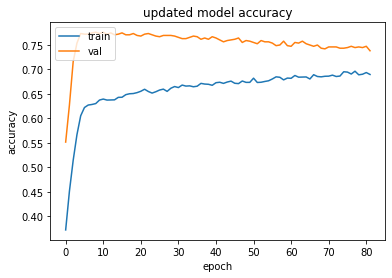

In [ ]:
plot_specialised(specialised_history)

In [ ]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised.save(trained_model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



##### Load Saved Model and Evaluate

In [9]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [10]:
# Generating Inputs

x_test_ohe,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test_ohe, y_test, batch_size=100)
y_pred = specialised_model.predict(x_test_ohe)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 3s 12ms/step - loss: 0.9254 - accuracy: 0.6502
test loss, test acc: [0.9253650307655334, 0.6502283215522766]


In [17]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                             precision    recall  f1-score   support

       A_APPROVED_ACTIVATED       0.00      0.00      0.00        74
       A_CANCELLED_DECLINED       0.37      0.23      0.28       308
       O_CANCELLED_DECLINED       0.32      0.18      0.23       383
                O_SENT_BACK       0.69      0.82      0.75       797
W_Assessing the application       0.76      1.00      0.86       628

                   accuracy                           0.65      2190
                  macro avg       0.43      0.45      0.43      2190
               weighted avg       0.58      0.65      0.60      2190



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix

[[  0   0   0   0  74]
 [  0  71  58 123  56]
 [  0  72  70 171  70]
 [  0  49  91 657   0]
 [  0   0   0   2 626]]


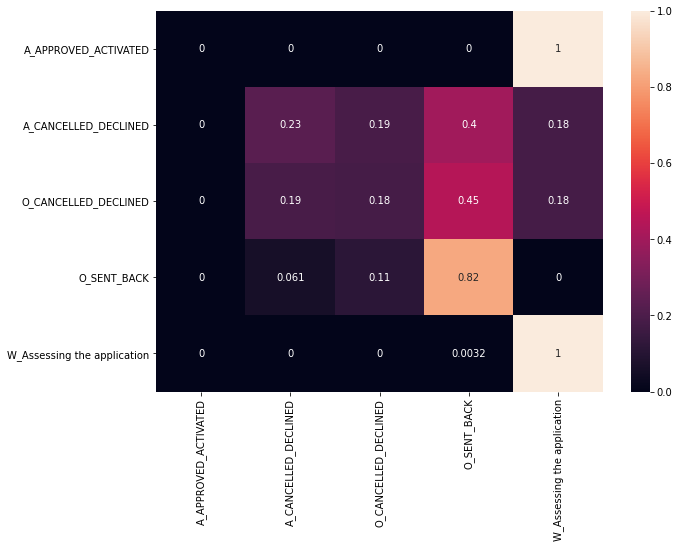

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [11]:
model_attn_weights = Model(inputs=specialised_model.input,
              outputs=[specialised_model.output, specialised_model.get_layer('timestep_attention').output,specialised_model.get_layer('ac_importance').output ,specialised_model.get_layer('rl_importance').output,specialised_model.get_layer('t_importance').output])

output_with_attention = model_attn_weights.predict(x_test_ohe)

###### Global Explanations

In [23]:
explain_global(output_with_attention,x_test,y_test,index_ac, index_rl,3,prediction=2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



###### Local Explanations

In [ ]:
df_results = results_df(y_test,y_pred,index_ne)
df_results [(df_results ['prediction'] == 'W_Assessing the application') & (df_results ['pred_class'] == True) & (df_results ['prediction_prob'] >=0.7) ].head(3)

,sample_index,prediction,ground_truth,prediction_prob,pred_class
3,3,W_Assessing the application,W_Assessing the application,0.7529,True
9,9,W_Assessing the application,W_Assessing the application,0.7353,True
15,15,W_Assessing the application,W_Assessing the application,0.7370,True


In [20]:
explain_local(output_with_attention,x_test,y_test,index_ac,index_rl,index_ne,3,53)

prediction: O_SENT_BACK
ground truth: O_CANCELLED_DECLINED
prediction probability:0.8064


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



process flowchart
st12=>start: start O_SENT
op13=>operation: W_Filling in information for the application_role_11169
op14=>operation: W_Calling after sent offers_role_11119
op15=>operation: W_Calling after sent offers_role_11119
op16=>operation: W_Calling after sent offers_role_10982

st12->op13
op13->op14
op14->op15
op15->op16



